In [1]:

## versions:
## Python    : 3.11.5
## numpy     : 1.26.0
## torch     : 2.1.0
## pandas    : 2.1.1

# licensed under the Creative Commons - Attribution-NonCommercial 4.0
# International license (CC BY-NC 4.0):
# https://creativecommons.org/licenses/by-nc/4.0/. 

import os
import io
import sys
import shutil
import datetime
from typing import Dict, List, Optional
from copy import deepcopy

import numpy as np
import pandas as pd
import torch as t
from torch.utils.data import DataLoader
from scipy import stats
import matplotlib.pyplot as plt

from common.torch.ops import empty_gpu_cache
from common.sampler import ts_dataset
from common.torch.snapshots import SnapshotManager
from experiments.trainer import trainer_var
from experiments.model import generic_dec_var
from models.exog import TCN_encoder

from data_utils.forecast import tryJSON, Struct, read_config, default_settings, make_training_fn
from data_utils.forecast import init_target_data, load_exog_data, make_training_fn, generate_quantiles
from data_utils.forecast import pickle_results, read_pickle, output_figs
from data_utils.covid_hub import domain_defaults, specify_ensemble, output_csv, download_training_data

`read_config()` returns configuration settings that don't change between models within an ensemble

gets values from `config.json` if available

see comments in `data_utils/forecast.py` for an explanation of entries

In [2]:
rstate = read_config()

In [3]:
rstate

target_file = h_3ma.csv
cut = None
output_prefix = nbxd
output_dir = storage/output
snapshot_dir = model_snapshots
data_dir = storage/training_data
delete_models = False
input_is_log = False
input_is_sqrt = False
log_transform = False
sqrt_transform = True
variance_scale = 1.0
qtiles = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]
calc_validation = True

you can change the settings here or in `config.json`

e.g., `rstate.cut` sets the train/test split index (None = train on all data)

In [4]:
rstate.cut = 915

`default_settings()` returns settings that can be changed between models within an ensemble

gets defaults from `settings.json` if available

see comments in `data_utils/forecast.py` for an explanation of entries

In [5]:
settings = default_settings()

can change settings in json file or here

In [6]:
#try increasing the learning rate when there's more training data
settings.init_LR = np.round(0.0001 + (rstate.cut - 901) * 4e-7, 7) 

we will change `settings.exog_vars` below, to specify which exogenous predictors to use

In [7]:
settings

exog_vars = None
iterations = 400
init_LR = 0.0001056
batch_size = 128
lookback = 4
horizon = 40
lfn_name = t_nll
force_positive_forecast = False
normalize_target = False
use_windowed_norm = True
use_static_cat = False
nbeats_stacks = 8
nbeats_hidden_dim = 512
nbeats_dropout = 0.2
encoder_k = 5
encoder_n = None
encoder_hidden_dim = 128
encoder_dropout = 0.2
enc_temporal = True
static_cat_embed_dim = 3
history_size_in_horizons = 60

`domain_defaults()` is meant to be a user-defined function

returns a struct with instructions for reading or generating exogenous variables

see `data_utils/covid_hub.py` for an example/explanation

In [8]:
domain_specs = domain_defaults()

`exog_vars` specifies which exogenous predictors to use by default

the predictors in `var_names` are loaded/generated and available to use

In [9]:
domain_specs

exog_vars = ['doy', 'dewpC']
lookback_opts = [3, 4, 5, 6]
random_reps = 5
var_names = ['tempC', 'dewpC', 'tsa_by_pop', 't', 't_decay', 'doy', 'vacc_rate', 't_voc', 'pop_density_2020', 'med_age_2023', 'wastewater', 'variant_p1', 'variant_p2', 'variant_p3', 'variant_other', 'variant_alpha', 'variant_gamma', 'variant_delta', 'variant_omicron']
var_files = ['tempC_7ma.csv', 'dewpC_7ma.csv', 'tsa_by_pop_daily.csv', None, None, None, 'vacc_full_pct_to_may23.csv', None, 'pop_density_2020.csv', 'med_age_2023.csv', 'wastewater_daily.csv', 'variant_p1.csv', 'variant_p2.csv', 'variant_p3.csv', 'variant_other.csv', 'variant_alpha.csv', 'variant_gamma.csv', 'variant_delta.csv', 'variant_omicron.csv']
var_fns = [None, None, None, <function proc_t at 0x158ff4fe0>, <function proc_tdecay at 0x158ff5080>, <function proc_doy at 0x158ff5120>, <function proc_fwd_const at 0x158ff4e00>, <function proc_tvoc at 0x158ff5800>, <function proc_const at 0x158ff4ea0>, <function proc_const at 0x158ff4ea0>, <function 

`init_target_data()` reads in and optionally transforms target data

sets timepoint indices and series identifiers; writes data to `rstate`


In [10]:
rstate, settings = init_target_data(rstate, settings)

`rstate.data_index` was set based on the index of `rstate.target_file`

for exogenous data, the files and functions specified in `domain_defaults()` must generate data frames with the same index

In [11]:
rstate.data_dir+"/"+rstate.target_file, rstate.data_index

('storage/training_data/h_3ma.csv',
 Index(['2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17', '2020-07-18',
        '2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
        ...
        '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09',
        '2023-01-10', '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-14'],
       dtype='object', name='date', length=915))

`load_exog_data()` appends exogenous predictors to rstate, using the data index generated above

In [12]:
rstate, settings = load_exog_data(rstate, settings, domain_specs)

`settings.exog_vars` now has the defaults from domain_specs (if this was not set in `settings.json`)

In [13]:
settings.exog_vars

['doy', 'dewpC']

the data has been read into `rstate` as a dict keyed by series name

each series is a data frame with rows as timepoints and columns as variables

In [14]:
rstate.series_dfs["11"]

,_NAT_SCALE,_SQRT,_SCALED,tempC,dewpC,tsa_by_pop,t,t_decay,doy,vacc_rate,...,med_age_2023,wastewater,variant_p1,variant_p2,variant_p3,variant_other,variant_alpha,variant_gamma,variant_delta,variant_omicron
date,,,,,,,,,,,,,,,,,,,,,
2020-07-14,7.50,2.738613,0.731925,1.298996,1.299212,0.350611,-2.000000,2.000000,0.142077,0.000000,...,-1.917719,1.000000,1.0000,0.0000,0.0000,1.000000,0.0,0.0,0.0,0.000000
2020-07-15,7.33,2.707397,0.723582,1.289169,1.234727,0.378993,-1.995624,1.997224,0.153005,0.000000,...,-1.917719,1.000000,1.0000,0.0000,0.0000,1.000000,0.0,0.0,0.0,0.000000
2020-07-16,8.33,2.886174,0.771362,1.276393,1.230819,0.451771,-1.991247,1.994452,0.163934,0.000000,...,-1.917719,1.000000,1.0000,0.0000,0.0000,1.000000,0.0,0.0,0.0,0.000000
2020-07-17,6.67,2.582634,0.690238,1.283272,1.223003,0.460431,-1.986871,1.991684,0.174863,0.000000,...,-1.917719,1.000000,1.0000,0.0000,0.0000,1.000000,0.0,0.0,0.0,0.000000
2020-07-18,6.67,2.582634,0.690238,1.319633,1.210301,0.414295,-1.982494,1.988920,0.185792,0.000000,...,-1.917719,1.000000,1.0000,0.0000,0.0000,1.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-10,25.67,5.066557,1.354094,-0.572123,-0.475095,1.014900,1.982494,0.565106,-1.890710,1.983710,...,-1.917719,1.255817,0.5920,0.2237,0.1676,0.004392,0.0,0.0,0.0,0.997270
2023-01-11,25.67,5.066557,1.354094,-0.733290,-0.658779,1.042032,1.986871,0.564322,-1.879781,1.997713,...,-1.917719,1.214905,0.5832,0.2363,0.1630,0.004453,0.0,0.0,0.0,0.996829
2023-01-12,23.67,4.865182,1.300275,-0.832546,-0.733034,1.324057,1.991247,0.563539,-1.868852,1.998475,...,-1.917719,1.172566,0.5741,0.2492,0.1584,0.004507,0.0,0.0,0.0,0.996388


the name of the target column was set automatically by `init_target_data()`

In [15]:
rstate.target_var

'_SQRT'

`make_training_fn()` returns a function that trains a model  (it closes over training data and config settings)

the resulting function takes `settings` and returns mean & variance forecasts

the forecasts are matrices with rows = series and columns = timepoints

the trained models are saved in `rstate.snapshot_dir`

the training function can be used on its own or called in a loop with different settings to generate an ensemble


In [16]:
training_fn = make_training_fn(rstate)

to train an ensemble of models, we will generate a list of `settings`, one for each model

`specify_ensemble` is a user-defined function that generates the list, based on info in `domain_specs`

see `data_utils/covid_hub.py` for an example

In [17]:
## maybe we don't really need 5 random reps
domain_specs.random_reps = 1 

## generate a list of settings structs having the desired variation for ensemble
## save the list to rstate for posterity
rstate.settings_list = specify_ensemble(settings, domain_specs)


can also define some other ensemble:

In [18]:
## setting size of hidden layer based on size of lookback window:
def custom_ensemble(template, specs):
    settings_list = []
    for j in range(specs.random_reps):
        for opt in specs.lookback_opts:
            x = deepcopy(template)
            x.lookback = opt
            x.nbeats_hidden_dim = opt * 80
            #x.encoder_hidden_dim = opt * 20
            settings_list.append(x)
    return settings_list


In [19]:
rstate.settings_list = custom_ensemble(settings, domain_specs)
rstate.settings_list[3]

exog_vars = ['doy', 'dewpC']
iterations = 400
init_LR = 0.0001056
batch_size = 128
lookback = 6
horizon = 40
lfn_name = t_nll
force_positive_forecast = False
normalize_target = False
use_windowed_norm = True
use_static_cat = False
nbeats_stacks = 8
nbeats_hidden_dim = 480
nbeats_dropout = 0.2
encoder_k = 5
encoder_n = None
encoder_hidden_dim = 128
encoder_dropout = 0.2
enc_temporal = True
static_cat_embed_dim = 3
history_size_in_horizons = 60

empty dicts for storing the forecasts from each model:

In [20]:
mu_fc={}
var_fc={}

In [21]:
empty_gpu_cache() ## just in case?

train each model in the ensemble and write its forecast to `mu_fc` and `var_fc` (keyed w/ a semi-descriptive name):

In [22]:

## ensemble loop
for i, set_i in enumerate(rstate.settings_list):
    model_name = rstate.output_prefix+"_"+str(i)
    model_suffix = str(rstate.cut) if rstate.cut is not None else str(rstate.data_index[-1])
    model_name = model_name+"_"+model_suffix
    print("training ",model_name)
    mu_fc[model_name], var_fc[model_name] = training_fn(model_name, set_i) 


training  nbxd_0_915


/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:26: UserWarning: The operator 'aten::_weight_norm_interface' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return _weight_norm(v, g, self.dim)
/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.war

training  nbxd_1_915
training  nbxd_2_915


/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


training  nbxd_3_915


/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


forecast shape for each model is [series, time]

ensemble the dict values using median across models

write results to `rstate`

In [23]:

mu_fc["ensemble"] = np.median(np.stack([mu_fc[k] for k in mu_fc]),axis=0)
var_fc["ensemble"] = np.median(np.stack([var_fc[k] for k in var_fc]),axis=0)

rstate.mu_fc = mu_fc
rstate.var_fc = var_fc


`generate_quantiles()` goes through each entry in `rstate.mu_fc` and `rstate.var_fc`

and generates dicts containing forecast quantiles for each model (and "ensemble")

see comments in `data_utils/forecast.py` for details

In [24]:
rstate = generate_quantiles(rstate)

optional: save rstate, which contains all training data, forecasts, and ensemble settings

`pickle_results()` writes it to output dir

In [25]:
pickle_results(rstate)

plot some forecasts

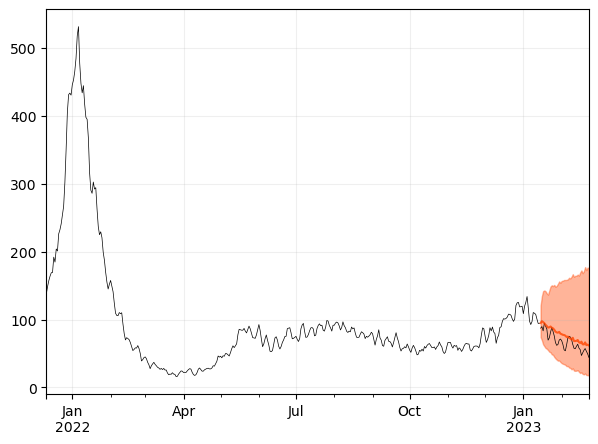

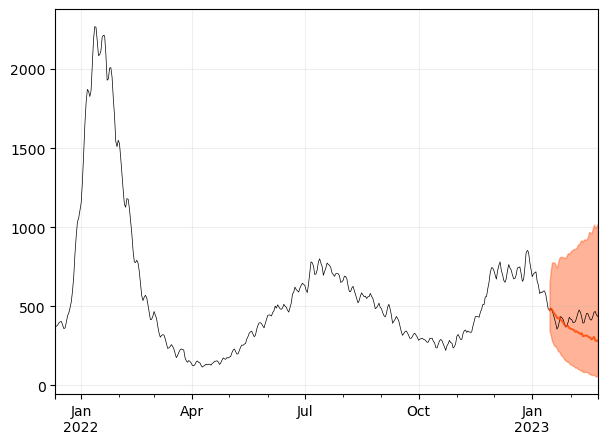

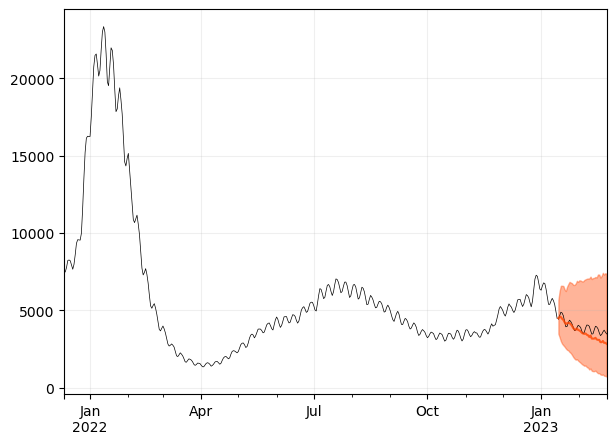

In [26]:
output_figs(rstate, settings.horizon, [20, 4], 400)

generate csv for submitting to covid-19 forecast hub

In [27]:
## for covid hub; forecasts start this many days after last day of data:
forecast_delay = 10 if rstate.cut > 1067 else 2
output_csv(rstate, forecast_delay)

writing  storage/output/2023-01-16-OHT_JHU-nbxd.csv


delete the trained models if we no longer need them:

In [28]:
if rstate.delete_models:
    try:
        shutil.rmtree(rstate.snapshot_dir)
    except:
        pass


automate the above

In [29]:
def init_rstate(cut, settings, domain_specs, ensemble_fn=specify_ensemble):
    rstate = read_config()
    rstate.cut = cut
    
    rstate, settings = init_target_data(rstate, settings)
    rstate, settings = load_exog_data(rstate, settings, domain_specs)
    rstate.settings_list = ensemble_fn(settings, domain_specs)
    
    return rstate, settings


def generate_ensemble(rstate):
    mu_fc={}
    var_fc={}
    empty_gpu_cache()
    training_fn = make_training_fn(rstate)

    ## ensemble loop
    for i, set_i in enumerate(rstate.settings_list):
        model_name = rstate.output_prefix+"_"+str(i)
        model_suffix = str(rstate.cut) if rstate.cut is not None else str(rstate.data_index[-1])
        model_name = model_name+"_"+model_suffix
        print("training ",model_name)
        mu_fc[model_name], var_fc[model_name] = training_fn(model_name, set_i) 

    mu_fc["ensemble"] = np.median(np.stack([mu_fc[k] for k in mu_fc]),axis=0)
    var_fc["ensemble"] = np.median(np.stack([var_fc[k] for k in var_fc]),axis=0)
    rstate.mu_fc = mu_fc
    rstate.var_fc = var_fc
    rstate = generate_quantiles(rstate)

    return rstate


def delete_model_dir(rstate):
    if rstate.delete_models:
        try:
            shutil.rmtree(rstate.snapshot_dir)
        except:
            pass


In [30]:

## try adjusting the amount of training based on the amount of training data history
## (lowering learning rate seems to work better than decreasing # of iterations)
def adapt_iter(x):
    return int(np.round(200 + (x - 901) * 2.0 / 3.0))

def adapt_lr(x):
    return np.round(0.0001 + (x - 901) * 4e-7, 7) 

def run_test(cut, random_reps=None, ensemble_fn=specify_ensemble, adj_iter=False, adj_LR=True):
    ## if adj_*, train more when there is more data; otherwise use values from settings.json
    settings = default_settings()
    if adj_iter: settings.iterations = adapt_iter(cut)
    if adj_LR: settings.init_LR = adapt_lr(cut)

    domain_specs = domain_defaults()
    if random_reps is not None: domain_specs.random_reps = random_reps
    
    rstate, settings = init_rstate(cut, settings, domain_specs, ensemble_fn)
    rstate = generate_ensemble(rstate)

    pickle_results(rstate)
    output_figs(rstate, rstate.settings_list[0].horizon, [20, 4], 400)

    ## for covid hub; forecasts start this many days after last day of data:
    forecast_delay = 10 if cut > 1067 else 2
    output_csv(rstate, forecast_delay)
    
    delete_model_dir(rstate)


In [31]:
## when ensembing different lookback window sizes:
## larger lookback window = more input nodes
## try adjusting the size of the hidden layers accordingly
def custom_ensemble(template, specs):
    settings_list = []
    for j in range(specs.random_reps):
        for opt in specs.lookback_opts:
            x = deepcopy(template)
            x.lookback = opt
            x.nbeats_hidden_dim = opt * 80
            #x.encoder_hidden_dim = opt * 20
            settings_list.append(x)
    return settings_list


training  nbxd_0_1180


/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


training  nbxd_1_1180


/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


training  nbxd_2_1180


/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


training  nbxd_3_1180


/Users/sasha/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


writing  storage/output/2023-10-16-OHT_JHU-nbxd.csv


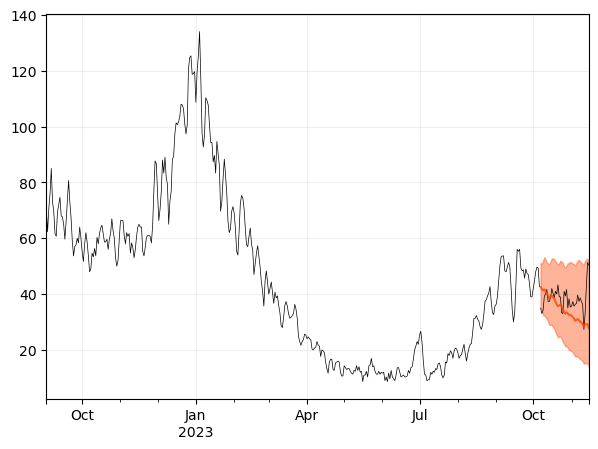

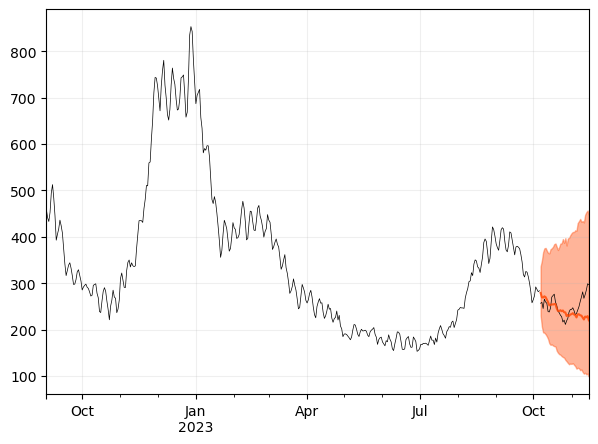

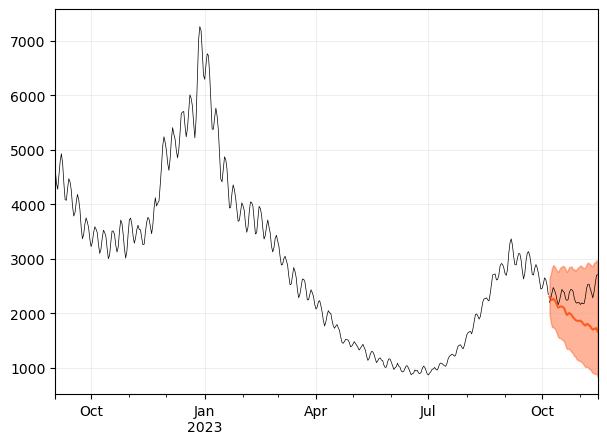

In [32]:
run_test(1180, 1, custom_ensemble)

graph training losses

note, ensembling not-quite-converged models seems to work better than running more iterations


In [33]:

def plot_losses(pickle_file):
    rstate = read_pickle(pickle_file)
    model_prefix = rstate.output_prefix
    model_suffix = str(rstate.cut) if rstate.cut is not None else str(rstate.data_index[-1])
    _, ax = plt.subplots(nrows=len(rstate.settings_list),ncols=2,figsize=[8,2*len(rstate.settings_list)])
    for i, set_i in enumerate(rstate.settings_list):
        model_name =  model_prefix+"_"+str(i)+"_"+model_suffix
        total_iter = set_i.iterations
        snapshot_manager = SnapshotManager(snapshot_dir=os.path.join(rstate.snapshot_dir, model_name), total_iterations=total_iter)
        ldf = snapshot_manager.load_training_losses()
        vdf = snapshot_manager.load_validation_losses()
        ax[i,0].plot(ldf)
        ax[i,1].plot(vdf)
    #plt.show()
    plt.savefig(os.path.join(rstate.output_dir , "losses_"+model_prefix+"_"+model_suffix+".png"))


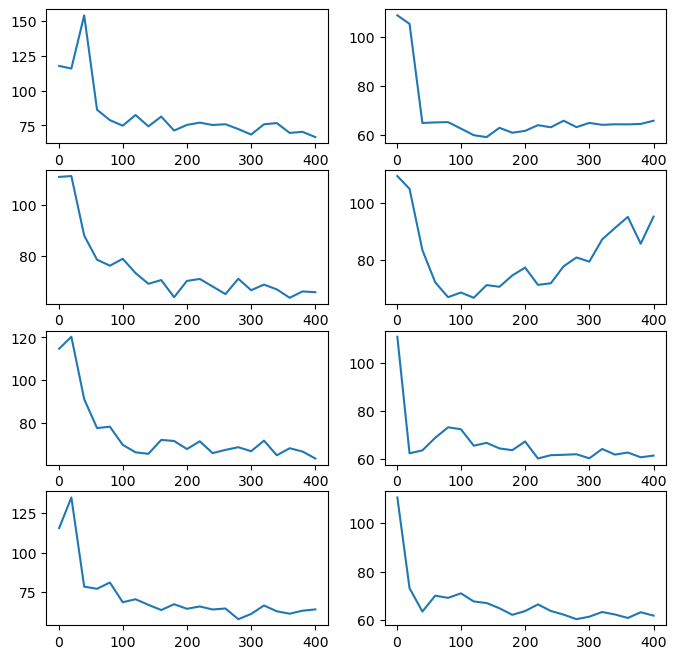

In [34]:
plot_losses(os.path.join(rstate.output_dir, "nbxd_915.pickle"))


In [ ]:
#rstate.delete_models = True
#delete_model_dir(rstate)